<a href="https://colab.research.google.com/github/AdaptiveMeteoSrl/meteoGNN/blob/main/HyperBatchGNNEmanuele.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from math import sqrt
from torch.utils.data import DataLoader
import pandas as pd
import torch
import torch.nn as nn
from torch import optim
import os
import time
import pickle as pc

from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from functools import partial

from sklearn.preprocessing import StandardScaler,MinMaxScaler
import matplotlib.pyplot as plt
import math
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.optim.lr_scheduler import StepLR
import datetime


class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model, path):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model, path)
            self.counter = 0

    def save_checkpoint(self, val_loss, model, path):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), path + '/' + 'checkpoint.pth')
        self.val_loss_min = val_loss

def media_mobile(serie_dati, periodi):
    medie_mobile = []
    for i in range(len(serie_dati) - periodi + 1):
        media = sum(serie_dati[i:i+periodi]) / periodi
        medie_mobile.append(media)
    return medie_mobile



In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [4]:
da = pd.read_csv("/content/gdrive/MyDrive/GIGADATAFRAME.csv")
da['DATE'] = pd.to_datetime(da['DATE'])
#da.set_index('DATE', inplace=True)


In [5]:
da['YEAR'] = da['DATE'].dt.year
da['MONTH'] = da['DATE'].dt.month
da['DAY'] = da['DATE'].dt.day
da['HOUR'] = da['DATE'].dt.hour

In [ ]:
#for i in range(5):
  #da["TEMPERATURA_STA{}".format(i)]=da["TEMP_STA{}".format(i)]
  #da.drop(columns="TEMP_STA{}".format(i),inplace=True)

In [6]:
for i in range(5):
  da.drop(columns="VELV_STA{}".format(i),inplace=True)
  da.drop(columns="DIRV_STA{}".format(i),inplace=True)
  da.drop(columns = "ANGLE_STA{}".format(i),inplace=True)

In [7]:
da.rename(columns={"PRESSIONE_STA4":"PRESS_STA4"},inplace=True)

In [8]:
da.drop(columns="PRESS_STA0",inplace=True)
da.drop(columns="PRESS_STA1",inplace=True)
da.drop(columns="PRESS_STA2",inplace=True)
da.drop(columns="PRESS_STA4",inplace=True)

In [9]:
#df.reset_index(inplace=True, drop=False)
df = da
print(df)

                      DATE  TEMP_STA0  TEMP_STA1  TEMP_STA2  TEMP_STA3  \
0      2017-12-31 23:00:00        0.4       -0.7       -0.5       -2.2   
1      2017-12-31 23:10:00        0.4       -0.8       -0.5       -2.2   
2      2017-12-31 23:20:00        0.5       -1.0       -0.4       -2.3   
3      2017-12-31 23:30:00        0.6       -1.1       -0.6       -2.3   
4      2017-12-31 23:40:00        0.5       -1.0       -0.6       -2.2   
...                    ...        ...        ...        ...        ...   
280683 2023-06-30 21:10:00       18.3       14.8       14.7        8.7   
280684 2023-06-30 21:20:00       18.2       14.7       14.6        8.7   
280685 2023-06-30 21:30:00       18.4       14.6       14.6        8.7   
280686 2023-06-30 21:40:00       18.6       14.6       14.6        8.7   
280687 2023-06-30 21:50:00       18.6       14.6       14.4        8.6   

        TEMP_STA4  HUM_STA0  HUM_STA1  HUM_STA2  HUM_STA3  ...  PRO_X_STA4  \
0            -0.7      91.9      

In [10]:
co = df.columns[1:]
from datetime import datetime, timedelta
df = df.reset_index(drop=True)

steps = 6  # Adjust this to your desired number of steps

date_info = pd.DataFrame()
# Create the new column by shifting the existing column
date_info['PREV_M'] = df['MONTH'].shift(-steps)
date_info["PREV_DAY"] = df['DAY'].shift(-steps)
date_info["PREV_H"] = df['HOUR'].shift(-steps)

# Fill the NaN values in the new column with a default value (e.g., 0)
df["PREV_M"] = date_info['PREV_M']
df["PREV_DAY"]=date_info["PREV_DAY"]
df["PREV_H"] =date_info["PREV_H"]

# Print the resulting DataFrame
df.drop(columns="YEAR",inplace=True)
df.drop(columns="MONTH",inplace=True)
df.drop(columns="DAY",inplace=True)
df.drop(columns="HOUR",inplace=True)



df = df.dropna()
df.reset_index(inplace = True,drop=True)



In [11]:

# Extract station names
station_names = ["STA0","STA1","STA2","STA3","STA4"]

# Reorder the columns
new_columns_order = ["DATE"]
for station in station_names:
    new_columns_order.extend([f'TEMP_{station}', f'HUM_{station}', f'PRO_X_{station}', f'PRO_Y_{station}'])

df = df[new_columns_order]

df["PREV_M"] = date_info['PREV_M']
df["PREV_DAY"]=date_info["PREV_DAY"]
df["PREV_H"] = date_info["PREV_H"]



<ipython-input-11-0f1ca8c41576>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PREV_M"] = date_info['PREV_M']
<ipython-input-11-0f1ca8c41576>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["PREV_DAY"]=date_info["PREV_DAY"]


In [ ]:
print(df)

                      DATE  TEMP_STA0  HUM_STA0  PRO_X_STA0  PRO_Y_STA0  \
0      2017-12-31 23:00:00        0.4      91.9    0.404495   -0.066964   
1      2017-12-31 23:10:00        0.4      92.0    0.283438    1.227706   
2      2017-12-31 23:20:00        0.5      91.8    0.336912    0.590669   
3      2017-12-31 23:30:00        0.6      90.6    0.097724    0.571708   
4      2017-12-31 23:40:00        0.5      91.2    0.149065    0.016720   
...                    ...        ...       ...         ...         ...   
280676 2023-06-30 20:10:00       18.8      91.1   -0.891241   -0.125256   
280677 2023-06-30 20:20:00       18.6      92.3   -1.315719   -0.720335   
280678 2023-06-30 20:30:00       18.7      88.7   -0.401578   -0.805441   
280679 2023-06-30 20:40:00       18.6      89.7   -0.256490   -0.757768   
280680 2023-06-30 20:50:00       18.6      89.7   -0.427950    0.420546   

        TEMP_STA1  HUM_STA1  PRO_X_STA1  PRO_Y_STA1  TEMP_STA2  ...  HUM_STA3  \
0            -0.7 

In [ ]:
print(df.columns[-7])

TEMP_STA4


In [31]:
desired_interval = 24*6              #Intervallo di tempo senza dati mancanti che vogliamo; deve essere maggiore o uguale a seq_len+pred_len

df["DATE"]=pd.to_datetime(df["DATE"])
desired_duration = timedelta(days=1)
good_starts = []
for i in range(df.shape[0]-desired_interval):                                      #Creo vettore di indici buoni per selezionare sequenze senza salti
  if df["DATE"][i+desired_interval]-df["DATE"][i] == desired_duration:
    good_starts.append(df.index[i])
#df = df.drop(columns="DATA_WDIR_STA4")                                            #SE VUOI PREVEDERE IL VENTO VA COMMENTATA QUESTA RIGA
fea = df.shape[1]-1
print(fea)
good_starts_train = good_starts[0:int(len(good_starts)*0.8)]                                    #Divido il vettore good_starts in indici iniziali di train e di validation
good_starts_vali = good_starts[int(len(good_starts)*0.8):int(len(good_starts))]
good_starts_vali = [l for l in good_starts_vali if l>(good_starts_train[-1]+desired_interval+1)] #Non voglio che train e validation si sovrappongano
#for i in range(len(good_starts_vali)):
  #good_starts_vali[i]= good_starts_vali[i]-good_starts_train[-1]-desired_interval-1
import random
shuffled_list = good_starts_train.copy()                                                        #Mischio il train
random.shuffle(shuffled_list)
tr = shuffled_list[0:64000]                                                                      #Scelgo un tot di indici da cui iniziare per le batch di train e un tot per validation
va = good_starts_vali[0:20000]                                                                   #Visto che altrimenti il train impiegherebbe giorni
gs=[tr,va]                                                                                      #Nel dataloader.train selezionerò il primo array di indici per scegliere indici (gs[0])



23


In [13]:
class Dataset():#'forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate')
    def __init__(self, root_path=None, flag='train', size=None,
                 features='MS',target='target', scale=True, timeenc=0, freq='10m'):

        # size [seq_len, label_len, pred_len]
        # info
        if size == None:
            print("size è none. Forse ci sono problemi")
        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['train', 'val']
        type_map = {'train': 0, 'val': 1}
        self.set_type = type_map[flag]

        self.features = features
        self.target = target
        self.scale = scale
        self.timeenc = timeenc
        self.freq = freq
        self.root_path = root_path
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = df

        border1s = [0, 0]
        border2s = [df_raw.shape[0], df_raw.shape[0]]
        border1 = border1s[self.set_type]
        border2 = border2s[self.set_type]


        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]

        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            stop_index = good_starts_train[-1]+desired_interval
            train_data = df_data.iloc[:stop_index + 1]
            self.scaler.fit(train_data.values)
            data = self.scaler.transform(df_data.values)
            self.scaler.fit(train_data['TEMP_STA4'].values.reshape(-1, 1))
            #data=data.values
        else:
            data = df_data.values

        self.data_x = data[border1:border2]
        self.data_y = data[border1:border2]


    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[s_begin:s_end+self.pred_len]

        return seq_x,seq_y

    def __len__(self):
        return len(self.data_x) - self.seq_len - self.pred_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


class Dataset_Pred(Dataset):
    def __init__(self, root_path=None, flag='train', size=None,
                 features='MS',
                 target='target', scale=True, timeenc=0, freq='10m'):
        if size == None:
            self.seq_len = 20
            self.label_len = 0
            self.pred_len = 6

        else:
            self.seq_len = size[0]
            self.label_len = size[1]
            self.pred_len = size[2]
        # init
        assert flag in ['pred']

        self.features = features
        self.target = target
        self.scale = "False"
        self.timeenc = timeenc
        self.freq = freq
        self.__read_data__()

    def __read_data__(self):
        self.scaler = StandardScaler()
        df_raw = df
        border1 = len(df_raw) - self.seq_len
        border2 = len(df_raw)

        if self.features == 'M' or self.features == 'MS':
            cols_data = df_raw.columns[1:]
            df_data = df_raw[cols_data]
        elif self.features == 'S':
            df_data = df_raw[[self.target]]

        if self.scale:
            self.scaler.fit(df_data.values)
            data = self.scaler.transform(df_data.values)
            self.scaler.fit(df_data['TEMP_STA4'].values.reshape(-1, 1))
            data=data.values
        else:
            data = df_data.values
        tmp_stamp = df_raw[['DATE']][border1:border2]
        tmp_stamp['DATE'] = pd.to_datetime(tmp_stamp["DATE"])
        pred_dates = pd.date_range(tmp_stamp.Date.values[-1], periods=self.pred_len + 1, freq=self.freq)
        df_stamp = pd.DataFrame(columns=['DATE'])
        df_stamp.DATE = list(tmp_stamp.DATE.values) + list(pred_dates[1:])
        if self.timeenc == 0:
            df_stamp['month'] = df_stamp["DATE"].apply(lambda row: row.month, 1)
            df_stamp['minute'] = df_stamp["DATE"].apply(lambda row: row.minute, 10)
            df_stamp['hour'] = df_stamp["DATE"].apply(lambda row: row.hour, 1)
            data_stamp = df_stamp.drop(labels=['DATE'], axis=1).values
            print(df_stamp)
            data_stamp = df_stamp.drop(labels=['DATE'], axis=1).values
        elif self.timeenc == 1:
            data_stamp = time_features(pd.to_datetime(df_stamp['DATE'].values), freq=self.freq)
            data_stamp = data_stamp.transpose(1, 0)

        self.data_x = data[border1:border2]

        self.data_y = data[border1:border2]
        self.data_stamp = data_stamp

    def __getitem__(self, index):
        s_begin = index
        s_end = s_begin + self.seq_len
        r_begin = s_end - self.label_len
        r_end = r_begin + self.label_len + self.pred_len

        seq_x = self.data_x[s_begin:s_end]
        seq_y = self.data_y[r_begin:r_begin + self.label_len]
        #seq_x_mark = self.data_stamp[s_begin:s_end]
        #seq_y_mark = self.data_stamp[r_begin:r_end]
        return seq_x, seq_y#, seq_x_mark, seq_y_mark

    def __len__(self):
        return len(self.data_x) - self.seq_len + 1

    def inverse_transform(self, data):
        return self.scaler.inverse_transform(data)


In [14]:

def make_adj_station(seq_len, n_nodes):
  adj = np.ones(shape=(n_nodes,n_nodes), dtype=np.float32)
  for i in range (n_nodes):
    adj[i][i]=0
  #ad = np.array([adj]*seq_len)
  ad = torch.from_numpy(adj)
  return(ad)

sta_ad = make_adj_station(1, 5)


In [15]:
print(sta_ad)

tensor([[0., 1., 1., 1., 1.],
        [1., 0., 1., 1., 1.],
        [1., 1., 0., 1., 1.],
        [1., 1., 1., 0., 1.],
        [1., 1., 1., 1., 0.]])


In [18]:
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

class Basic_Graph_Conv(nn.Module):
  def __init__(self, in_feat, out_feat):
    super(Basic_Graph_Conv, self).__init__()
    self.in_feat = in_feat
    self.out_feat = out_feat
    self.W2 = Parameter(torch.rand((in_feat, out_feat), dtype=torch.float32))
    #self.W2 = nn.Parameter(torch.empty(*(in_feat, out_feat)))
    #init.normal_(self.W2, mean=0.0, std=0.1)
    self.W1 = Parameter(torch.rand((in_feat, out_feat), dtype=torch.float32))
    self.bias = Parameter(torch.zeros(out_feat, dtype=torch.float32))



  def forward(self, X, A):
    x = torch.mm(X,self.W2)
    x = torch.mm(A,x)
    root = torch.mm(X,self.W1)
    out = x + root + self.bias
    return out

In [19]:
class NodeNetwork(torch.nn.Module):

    def __init__(self, input_features):
        super().__init__()

        # network architecture: two graph convolutional layers
        self.conv_1 = Basic_Graph_Conv(1, 16)# this is the graph conv
        self.conv_2 = Basic_Graph_Conv(16, 1)
        self.LSTM = nn.LSTM(input_size= 21, num_layers=2, hidden_size = 32, batch_first=True)
        self.conv_3 = Basic_Graph_Conv(4, 16)
        self.conv_4 = Basic_Graph_Conv(16,4)

        # followed by an MLP
        self.fc_1 = torch.nn.Linear(32, 64)
        self.fc_2 = torch.nn.Linear(64, 20)

    def forward(self, X, A, STA):

      x = X[:,:,:-3]
      t = X[:,:,-1:]
      t = t.reshape(X.shape[0],X.shape[1], 1)
      x = x.reshape(X.shape[0],-1, 1)

      h = torch.empty(0,X.shape[1]*20,1,requires_grad=True)
      for i in range(X.shape[0]):
        h_x = (self.conv_1(x[i],A))
        h_y = (self.conv_2(h_x,A))
        h_y = h_y.reshape(1,-1,1)
        h = torch.cat((h,h_y),dim=0)
      y_x = h.reshape(X.shape[0],X.shape[1],5,4)

      #y_x = torch.empty(64,20,5,4)
      #z_x = torch.empty(64,20,5,16)
      #for i in range(z_x.shape[0]):
        #for j in range(z_x.shape[1]):
          #z_x[i][j] = self.conv_3(x[i][j],STA)
          #y_x[i][j] = self.conv_4(z_x[i][j],STA)
      #y_x = x.reshape(64,20,-1)


      y_x = y_x.reshape(X.shape[0],20,-1)
      a_x = torch.cat((t,y_x),dim=2)
      r_x, _ = self.LSTM(a_x)
      r_x = r_x[:,-1, :]
      r_x = self.fc_1(r_x)
      r_x = self.fc_2(r_x)


      b = torch.empty(0,5,4,requires_grad = True)
      r_x = r_x.view(X.shape[0],5,4)

      for k in range(X.shape[0]):
        b_x = (self.conv_3(r_x[k],STA))
        b_y = (self.conv_4(b_x,STA))
        b_y = b_y.reshape(1,5,4)
        b = torch.cat((b,b_y),dim=0)

      output = b.view(X.shape[0],-1,1)
      output = output[:,-4,:]
      output = output.reshape(X.shape[0])


        # input the pooled representation to a MLP that classify the event

      return output

In [20]:
num_stations = 5
num_features_per_station = 4
num_features_total = num_stations * num_features_per_station
num_timestamp_columns = 0

# Initialize an empty adjacency matrix with zeros
adjacency_matrix = torch.zeros((num_features_total + num_timestamp_columns, num_features_total + num_timestamp_columns), dtype=int)

# Define connections between features of each station
for station in range(num_stations):
    start_idx = station * num_features_per_station
    end_idx = start_idx + num_features_per_station
    adjacency_matrix[start_idx:end_idx, start_idx:end_idx] = 1  # Features of each station connected to each other

# Define connections from timestamps to features
# Timestamps influence features but not the other way around
adjacency_matrix[num_features_total:, :num_features_total] = 1

i = 13  # Replace this with the index of the feature you want to drop

# Drop the i-th row and column from the adjacency matrix

# Print the adjacency matrix (for illustration)


for i in range(adjacency_matrix.shape[0]):
    adjacency_matrix[i, i] = 0

print(adjacency_matrix)

initial_matrix = adjacency_matrix
seq_len = 20

# Calculate the dimensions of the resulting block matrix
block_matrix_size = seq_len * initial_matrix.size(0)

# Initialize the block matrix with zeros
block_matrix = torch.zeros(block_matrix_size, block_matrix_size)

# Fill the diagonal blocks with the initial matrix
for i in range(seq_len):
    start_row = i * initial_matrix.size(0)
    end_row = (i + 1) * initial_matrix.size(0)
    block_matrix[start_row:end_row, start_row:end_row] = initial_matrix

# Print the resulting block matrix
ad = block_matrix

# Print the adjacency matrix
print(ad.shape)


tensor([[0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0],
        [0, 0, 0, 0,

In [21]:
class DNNModel(object):
    def __init__(self,batch_size,epochs_early_stopping=20):
        self.embed='fixed'
        self.batch_size=16
        self.freq='10m'
        self.num_workers=0
        self.pred_len=6
        self.label_len=0
        self.seq_len= 20
        self.n_features=20
        self.nodes= self.seq_len * self.n_features
        self.model = self._build_model()
        self.use_amp=False
        self.train_epochs=20
        self.features='MS'
        self.output_attention=True
        self.device = "cpu"#torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.checkpoints='./checkpoints/'
        self.lr=0.001


    def data_provider(self,flag):
        data_dict = {
            'ETTh1': Dataset
        }
        Data = data_dict['ETTh1']
        timeenc = 0 if self.embed == 'timeF' else 1
        if flag == 'val':

            v_s = 1
            shuffle_flag = False
            drop_last = True
            batch_size =  1
            freq = self.freq
        else:

            v_s = 0
            shuffle_flag=True
            drop_last = True
            batch_size = 16
            freq = self.freq

        data_set = Data(
            flag=flag,
            size=[self.seq_len, self.label_len,self.pred_len],
            freq=self.freq
        )


        print(flag, len(data_set))
        data_loader = DataLoader(
            data_set,
            batch_size=batch_size,
            num_workers=self.num_workers,
            drop_last=drop_last,
            sampler = SpecificIndicesSampler(gs[v_s]))
        return data_set, data_loader

    def _build_model(self):

        model = NodeNetwork(input_features = self.nodes)
        return model

    def _select_optimizer(self):
        model_optim = optim.Adam(self.model.parameters(), lr=self.lr)
        return model_optim

    def _select_criterion(self):
        criterion = nn.MSELoss()#nn.MSELoss()#nn.CrossEntropyLoss()#nn.BCELoss()#nn.BCEWithLogitsLoss() #nn.NLLLoss()#nn.HuberLoss(reduction='mean', delta=1.0)#nn.MSELoss()#nn.BCELoss()#nn.L1Loss()#nn.HuberLoss(reduction='mean', delta=1.0)#nn.MSELoss()#nn.HuberLoss(reduction='mean', delta=1.0)#nn.MSELoss()
        return criterion

    def _get_data(self, flag):
        data_set, data_loader = self.data_provider(flag)
        return data_set, data_loader

    def vali(self, vali_data, vali_loader, criterion):
        total_loss = []
        self.model.eval()
        with torch.no_grad():
          for i, (batch_x,batch_y) in enumerate(vali_loader):
            batch_x = batch_x.float().to(self.device)
            #batch_x = batch_x.float().view(20,20,1).to(self.device)
            batch_y = batch_y.float().to(self.device)
            outputs = self.model(batch_x.to(self.device),ad.to(self.device),sta_ad.to(self.device))
            outputs = outputs.to(self.device)
            batch_y = batch_y[:,-1,-7].to(self.device)


            pred = outputs.detach().cpu()
            true = batch_y.detach().cpu()

            loss = torch.nn.functional.l1_loss(pred, true)
            total_loss.append(loss)

        total_loss = np.average(total_loss)

        return total_loss


    def train(self,setting):

        self.model.to(self.device)
        self.model.train()
        train_data, train_loader = self._get_data(flag='train')
        vali_data, vali_loader = self._get_data(flag='val')
        #test_data, test_loader = self._get_data(flag='test')

        path = os.path.join(self.checkpoints, setting)
        if not os.path.exists(path):
            os.makedirs(path)

        #time_now = time.time()

        train_steps = len(train_loader)
        early_stopping = EarlyStopping(patience=100, verbose=True)

        model_optim = self._select_optimizer()
        criterion = self._select_criterion()
        #scheduler = StepLR(model_optim, step_size = 5, gamma = 0.15)
        scheduler = ReduceLROnPlateau(model_optim, mode='min', patience=3, factor=0.3, verbose=False)
        if self.use_amp:
            scaler = torch.cuda.amp.GradScaler()

        for epoch in range(self.train_epochs):
            iter_count = 0
            train_loss = []
            self.model.train()
            #epoch_time = time.time()
            for i, (batch_x, batch_y) in enumerate(train_loader):
                iter_count += 1
                model_optim.zero_grad()
                #batch_x = batch_x.float().view(20,20,1).to(self.device)

                batch_x = batch_x.float().to(self.device)
                batch_y = batch_y.float().to(self.device)

                outputs = self.model(batch_x.to(self.device),ad.to(self.device),sta_ad.to(self.device))



                outputs = outputs.to(self.device)
                batch_y = batch_y[:,-1,-7].to(self.device)
                batch_y = batch_y.to(self.device)

                #print("Outputs:", outputs.shape)
                #print("Targets:", batch_y.shape)
                loss = criterion(outputs, batch_y)
                train_loss.append(loss.item())
                #print("fine")
                if (i + 1) % 100 == 0:
                    #print("\titers: {0}, epoch: {1} | loss: {2:.7f}".format(i + 1, epoch + 1, loss.item()))
                    #speed = (time.time() - time_now) / iter_count
                    #left_time = speed * ((self.train_epochs - epoch) * train_steps - i)
                    #print('\tspeed: {:.4f}s/iter; left time: {:.4f}s'.format(speed, left_time))
                    iter_count = 0
                    #time_now = time.time()

                if self.use_amp:
                    scaler.scale(loss).backward()
                    scaler.step(model_optim)
                    scaler.update()
                else:
                    loss.backward()
                    model_optim.step()

            print("Epoch: {}".format(epoch + 1))
            train_loss = np.average(train_loss)
            vali_loss= self.vali(vali_data, vali_loader, criterion)

            #scheduler.step()
            scheduler.step(vali_loss)
            #test_loss = self.vali(test_data, test_loader, criterion)

            #print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f} Test Loss: {4:.7f}".format(
            #    epoch + 1, train_steps, train_loss, vali_loss, test_loss))
            print("Epoch: {0}, Steps: {1} | Train Loss: {2:.7f} Vali Loss: {3:.7f}".format(
                epoch + 1, train_steps, train_loss, vali_loss))
            early_stopping(vali_loss, self.model, path)
            if early_stopping.early_stop:
                print("Early stopping")
                break

        best_model_path = path + '/' + 'checkpoint.pth'
        self.model.load_state_dict(torch.load(best_model_path))
        return self.model




    def vali_test(self, setting, test=True):
        test_data, test_loader = self._get_data(flag='val')
        if test:
            print('loading model')
            self.model.load_state_dict(torch.load(os.path.join('./checkpoints/' + setting, 'checkpoint.pth')))

        preds = []
        trues = []
        folder_path = './test_results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        self.model.eval()
        with torch.no_grad():
            for i, (batch_x, batch_y) in enumerate(test_loader):
              #batch_x = batch_x.float().view(20,20,1)
              batch_x = batch_x.float()
              batch_y = batch_y.float()
              outputs = self.model(batch_x,ad,sta_ad)

              batch_y = batch_y[:, -1, -7]
              #outputs =torch.argmax(outputs, dim=1)
              batch_y = batch_y
              outputs = outputs.detach().numpy()
              batch_y = batch_y.detach().numpy()
              pred = outputs  # outputs.detach().cpu().numpy()  # .squeeze()
              true = batch_y  # batch_y.detach().cpu().numpy()  # .squeeze()
              preds.append(pred)
              trues.append(true)


        preds = np.array(preds)
        trues = np.array(trues)
        print('test shape:', preds.shape, trues.shape)
        preds = preds.reshape(-1, preds.shape[-1])
        trues = trues.reshape(-1, trues.shape[-2], trues.shape[-1])
        print('test shape:', preds.shape, trues.shape)

        # result save
        folder_path = './results/' + setting + '/'
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        return preds,trues

In [22]:
from torch.utils.data import Sampler

class SpecificIndicesSampler(Sampler):
    def __init__(self, indices):
        self.indices = indices

    def __iter__(self):
        return iter(self.indices)

    def __len__(self):
        return len(self.indices)


In [23]:
def _build_space():
    space = {
        'batch_size': 500 #hp.quniform('batch_size',100,101,1),
        }
    return space



def _hyperopt_objective(hyperparameters, trials, trials_file_path, max_evals):

    #print(hyperparameters)


    pc.dump(trials, open(trials_file_path, "wb"))
    setting = '{}'.format('EMANUELE')

    forecaster = DNNModel(
        batch_size=int(hyperparameters['batch_size'])
                     )

    forecaster.train(setting).to("cpu")
    Yp_mean ,Y_test= forecaster.test(setting,test=True)


    #Y_test = Dataset().inverse_transform(Y_test.reshape(-1, Y_test.shape[-1])).flatten()
    #Yp_mean = Dataset().inverse_transform(Yp_mean.reshape(-1, Yp_mean.shape[-1])).flatten()
    #print("Yp_mean",Yp_mean)
    #print("Y_test",Y_test)

    mae_validation = np.mean(MAE(Yp_mean, Y_test))
    smape_validation = np.mean(sMAPE(Y_test, Yp_mean))*100
    return_values = {'loss': mae_validation, 'MAE Val': mae_validation,'sMAPE Val': smape_validation,
                     'status': STATUS_OK}

    if trials.losses()[0] is not None:
        MAEVal = trials.best_trial['result']['MAE Val']
        sMAPEVal = trials.best_trial['result']['sMAPE Val']

        print('\n\nTested {}/{} iterations.'.format(len(trials.losses()) - 1,
              max_evals))
        print('Best MAE - Validation Dataset')
        print("  MAE: {:.1f} | sMAPE: {:.2f} %".format(MAEVal, sMAPEVal))
    return return_values

def hyperparameter_optimizer(path_hyperparameters_folder=os.path.join('.', 'experimental_files'),
                             new_hyperopt=1, max_evals=1500,
                             experiment_id=None):

    if not os.path.exists(path_hyperparameters_folder):
        os.makedirs(path_hyperparameters_folder)
    if experiment_id is None:
        experiment_id = datetime.now().strftime("%d-%m-%Y_%H:%M:%S")
    else:
        experiment_id = experiment_id
    trials_file_name = 'DNN_hyperparameters_SP500_15m_try3'
    trials_file_path = os.path.join(path_hyperparameters_folder, trials_file_name)
    if new_hyperopt:
        trials = Trials()
    else:
        trials = pc.load(open(trials_file_path, "rb"))
    # n_exogenous_inputs = len(df.columns) - 1
    space = _build_space()

    fmin_objective = partial(_hyperopt_objective, trials=trials, trials_file_path=trials_file_path,
                             max_evals=max_evals)
    fmin(fmin_objective, space=space, algo=tpe.suggest, max_evals=max_evals, trials=trials, verbose=False)

In [ ]:
new_hyperopt = 1#0.0065117
experiment_id = 1
max_evals = 1
path_hyperparameters_folder = "./experimental_files/"
hyperparameter_optimizer(path_hyperparameters_folder=path_hyperparameters_folder,
                         new_hyperopt=new_hyperopt, max_evals=max_evals,
                         experiment_id=experiment_id)#0.0814 di mae nell'articolo#0.0145(0.0037) MSE'''

train 280656
val 280656
Epoch: 1
Epoch: 1, Steps: 4000 | Train Loss: 0.0772203 Vali Loss: 0.1022037
Validation loss decreased (inf --> 0.102204).  Saving model ...


In [29]:
def MAE(pred, true):
    return np.mean(np.abs(pred - true))


def MSE(pred, true):
    return np.mean((pred - true) ** 2)


def RMSE(pred, true):
    return np.sqrt(MSE(pred, true))


def MAPE(pred, true):
    return np.mean(np.abs((pred - true) / true))


def MSPE(pred, true):
    return np.mean(np.square((pred - true) / true))

val 280656
loading model
test shape: (1000, 1) (1000, 1)
test shape: (1000, 1) (1, 1000, 1)
(1000, 1)
(1, 1000, 1)
MAE: 0.054 | MAPE: 28.689849 % | MSE: 0.005288
MAE: 0.406 | MAPE: 45.5207 % | MSE: 0.3008


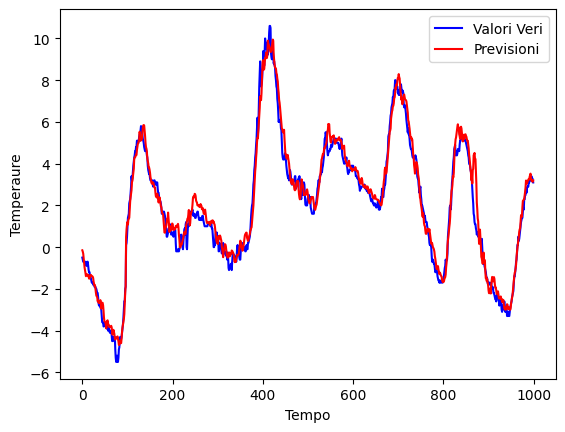

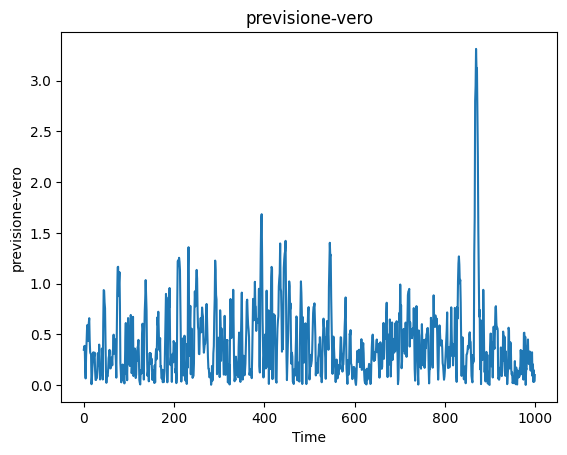

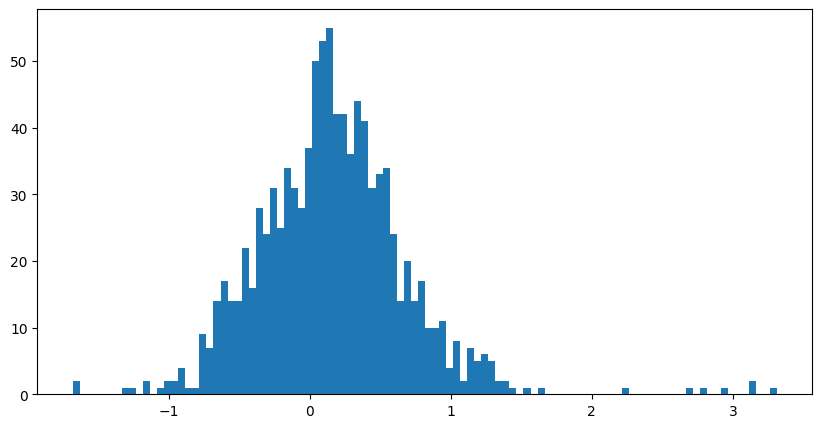

media istogramma 0.16084094


In [30]:
label_len=0
seq_len=20
pred_len=6
forecaster = DNNModel(batch_size=1)
setting = '{}'.format('EMANUELE')
Yp_mean ,Y_test= forecaster.vali_test(setting, test=True)
Yp_mean =Yp_mean
print(Yp_mean.shape)
print(Y_test.shape)
Y_test=Y_test
data=Dataset(flag='val',size=[seq_len,label_len,pred_len],freq='10m')
mae_validation = np.mean(MAE(Yp_mean, Y_test))
mse_validation = np.mean(MSE(Yp_mean, Y_test))
smape_validation = np.mean(MAPE(Y_test, Yp_mean))*100
print("MAE: {:.3f} | MAPE: {:.6f} % | MSE: {:.6f}".format(mae_validation, smape_validation,mse_validation))
Y_test = data.inverse_transform((Y_test.reshape(-1, 1))).flatten()
Yp_mean = data.inverse_transform((Yp_mean.reshape(-1, 1))).flatten()
mae_validation = np.mean(MAE(Yp_mean, Y_test))
mse_validation = np.mean(MSE(Yp_mean, Y_test))
smape_validation = np.mean(MAPE(Y_test, Yp_mean))*100
time = range(len(Y_test))
print("MAE: {:.3f} | MAPE: {:.4f} % | MSE: {:.4f}".format(mae_validation, smape_validation,mse_validation))
plt.plot(time, Y_test.flatten(), color='blue', label='Valori Veri')
plt.plot(time, Yp_mean.flatten(), color='red', label='Previsioni')
plt.xlabel('Tempo')
plt.ylabel('Temperaure')
plt.legend()
plt.show()
differenza=np.abs(Yp_mean-Y_test).flatten()
time = range(len(differenza))
plt.plot(time, differenza, label='previsione-vero')
plt.xlabel('Time')
plt.ylabel('previsione-vero')
plt.title('previsione-vero')
plt.show()
difference=(Yp_mean-Y_test).flatten()
plt.figure(figsize=(10,5),dpi=100)
plt.hist(difference,bins=100)
plt.show()
print("media istogramma",np.mean(difference))